# 🏭 Usines Intelligentes - ML Pipeline Tutorial

Ce notebook démontre l'implémentation complète du pipeline ML pour la maintenance prédictive:

1. **Data Preprocessing** - Chargement et nettoyage des données NASA C-MAPSS
2. **Feature Extraction** - Extraction de features temporelles et fréquentielles
3. **Anomaly Detection** - Détection d'anomalies avec Isolation Forest et LSTM Autoencoder
4. **RUL Prediction** - Prédiction de la durée de vie résiduelle avec LSTM et XGBoost
5. **Model Evaluation** - Évaluation et visualisation des performances
6. **Fine-Tuning** - Techniques d'optimisation des hyperparamètres

---


## 📦 Installation et Imports


In [30]:
# Installation des dépendances (exécuter une seule fois)
#!pip install numpy pandas matplotlib seaborn scikit-learn torch xgboost pyod scipy optuna mlflow tqdm


In [3]:
# Imports standards
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print("📦 Loading libraries...")

# Fast imports first
from pathlib import Path

# ML Libraries
print("   Loading scikit-learn...")
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

# Anomaly Detection
print("   Loading anomaly detection libraries...")
from pyod.models.iforest import IForest
from sklearn.svm import OneClassSVM

# Scipy pour le traitement du signal
print("   Loading scipy...")
from scipy import signal
from scipy.fft import fft, fftfreq

# XGBoost
print("   Loading XGBoost...")
import xgboost as xgb

# Deep Learning (can be slow - especially CUDA check)
print("   Loading PyTorch (this may take a moment)...")
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Visualisation
print("   Loading visualization libraries...")
import matplotlib.pyplot as plt
import seaborn as sns

# Hyperparameter tuning
print("   Checking for Optuna...")
try:
    import optuna
    OPTUNA_AVAILABLE = True
    print("   ✓ Optuna available")
except ImportError:
    OPTUNA_AVAILABLE = False
    print("   ⚠ Optuna non disponible - Fine-tuning avancé désactivé")

# Progress bar
from tqdm import tqdm

# Configuration
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    # Fallback if style doesn't exist
    plt.style.use('default')
    print("   ⚠ Using default matplotlib style")

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Device pour PyTorch (this can be slow if checking CUDA)
print("   Checking for GPU...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ All libraries loaded!")
print(f"🔧 Device: {device}")
print(f"📊 PyTorch version: {torch.__version__}")

📦 Loading libraries...
   Loading scikit-learn...
   Loading anomaly detection libraries...
   Loading scipy...
   Loading XGBoost...
   Loading PyTorch (this may take a moment)...
   Loading visualization libraries...
   Checking for Optuna...
   ✓ Optuna available
   Checking for GPU...
✅ All libraries loaded!
🔧 Device: cpu
📊 PyTorch version: 2.9.1+cpu


---
## 1. 📊 Data Preprocessing - Chargement et Nettoyage

Le dataset NASA C-MAPSS contient des données de simulation de moteurs d'avion avec:
- **26 colonnes**: unit_id, cycle, 3 settings, 21 sensors
- **4 scénarios** (FD001-FD004) avec différentes conditions de fonctionnement


In [4]:
# Définir les noms de colonnes pour le dataset C-MAPSS
COLUMN_NAMES = [
    'unit_id', 'cycle',
    'setting_1', 'setting_2', 'setting_3',
    'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
    'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10',
    'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
    'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
    'sensor_21'
]

# Chemins vers les données
DATA_PATH = Path('C:/Users/Asus/Desktop/Microservices/usines_intelligentes_new/datasets/nasa-cmapss')

def load_cmapss_data(dataset_name='FD001'):
    """Charge les données C-MAPSS train et test"""
    train_path = DATA_PATH / f'train_{dataset_name}.txt'
    train_df = pd.read_csv(train_path, sep=r'\s+', header=None, names=COLUMN_NAMES)

    test_path = DATA_PATH / f'test_{dataset_name}.txt'
    test_df = pd.read_csv(test_path, sep=r'\s+', header=None, names=COLUMN_NAMES)

    rul_path = DATA_PATH / f'RUL_{dataset_name}.txt'
    rul_df = pd.read_csv(rul_path, header=None, names=['RUL'])

    print(f"📁 Dataset {dataset_name} chargé:")
    print(f"   Train: {train_df.shape[0]} lignes, {len(train_df['unit_id'].unique())} moteurs")
    print(f"   Test: {test_df.shape[0]} lignes, {len(test_df['unit_id'].unique())} moteurs")

    return train_df, test_df, rul_df

def load_all_datasets():
    """Charge tous les datasets C-MAPSS et les combine"""
    datasets = ['FD001', 'FD002', 'FD003', 'FD004']

    all_train = []
    all_test = []
    all_rul = []
    dataset_info = {}

    for ds_name in datasets:
        print(f"\n{'='*50}")
        train_df, test_df, rul_df = load_cmapss_data(ds_name)

        # Ajouter un préfixe au unit_id pour éviter les conflits
        train_df['unit_id'] = train_df['unit_id'].apply(lambda x: f"{ds_name}_{x}")
        test_df['unit_id'] = test_df['unit_id'].apply(lambda x: f"{ds_name}_{x}")

        # Ajouter une colonne pour identifier le dataset
        train_df['dataset'] = ds_name
        test_df['dataset'] = ds_name
        rul_df['dataset'] = ds_name

        dataset_info[ds_name] = {
            'n_train_engines': len(train_df['unit_id'].unique()),
            'n_test_engines': len(test_df['unit_id'].unique()),
            'n_train_samples': len(train_df),
            'n_test_samples': len(test_df)
        }

        all_train.append(train_df)
        all_test.append(test_df)
        all_rul.append(rul_df)

    # Combiner tous les datasets
    combined_train = pd.concat(all_train, ignore_index=True)
    combined_test = pd.concat(all_test, ignore_index=True)
    combined_rul = pd.concat(all_rul, ignore_index=True)

    print(f"\n{'='*50}")
    print(f"📊 RÉSUMÉ GLOBAL:")
    print(f"   Total Train: {len(combined_train)} lignes, {len(combined_train['unit_id'].unique())} moteurs")
    print(f"   Total Test: {len(combined_test)} lignes, {len(combined_test['unit_id'].unique())} moteurs")

    return combined_train, combined_test, combined_rul, dataset_info

# Charger TOUS les datasets
train_df, test_df, rul_df, dataset_info = load_all_datasets()

# Afficher les statistiques par dataset
print("\n📊 Statistiques par dataset:")
for ds, info in dataset_info.items():
    print(f"   {ds}: {info['n_train_engines']} moteurs train, {info['n_test_engines']} moteurs test")


📁 Dataset FD001 chargé:
   Train: 20631 lignes, 100 moteurs
   Test: 13096 lignes, 100 moteurs

📁 Dataset FD002 chargé:
   Train: 53759 lignes, 260 moteurs
   Test: 33991 lignes, 259 moteurs

📁 Dataset FD003 chargé:
   Train: 24720 lignes, 100 moteurs
   Test: 16596 lignes, 100 moteurs

📁 Dataset FD004 chargé:
   Train: 61249 lignes, 249 moteurs
   Test: 41214 lignes, 248 moteurs

📊 RÉSUMÉ GLOBAL:
   Total Train: 160359 lignes, 709 moteurs
   Total Test: 104897 lignes, 707 moteurs

📊 Statistiques par dataset:
   FD001: 100 moteurs train, 100 moteurs test
   FD002: 260 moteurs train, 259 moteurs test
   FD003: 100 moteurs train, 100 moteurs test
   FD004: 249 moteurs train, 248 moteurs test


In [5]:
# Afficher les premières lignes
print("📋 Aperçu des données d'entraînement:")
train_df.head(10)


📋 Aperçu des données d'entraînement:


,unit_id,cycle,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,dataset
0,FD001_1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,FD001
1,FD001_1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,FD001
2,FD001_1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,FD001
3,FD001_1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,FD001
4,FD001_1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,FD001
5,FD001_1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,...,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,FD001
6,FD001_1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,...,2388.03,8132.32,8.3974,0.03,392,2388,100.0,39.10,23.3774,FD001
7,FD001_1,8,-0.0034,0.0003,100.0,518.67,642.56,1582.96,1400.97,14.62,...,2388.03,8131.07,8.4076,0.03,391,2388,100.0,38.97,23.3106,FD001
8,FD001_1,9,0.0008,0.0001,100.0,518.67,642.12,1590.98,1394.80,14.62,...,2388.05,8125.69,8.3728,0.03,392,2388,100.0,39.05,23.4066,FD001
9,FD001_1,10,-0.0033,0.0001,100.0,518.67,641.71,1591.24,1400.46,14.62,...,2388.06,8129.38,8.4286,0.03,393,2388,100.0,38.95,23.4694,FD001


In [6]:
# Statistiques descriptives
print("📊 Statistiques des capteurs:")
sensor_cols = [col for col in COLUMN_NAMES if 'sensor' in col]
train_df[sensor_cols].describe().round(3)


📊 Statistiques des capteurs:


,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
count,160359.000,160359.000,160359.000,160359.000,160359.000,160359.000,160359.000,160359.000,160359.000,160359.000,...,160359.000,160359.000,160359.000,160359.000,160359.000,160359.000,160359.000,160359.000,160359.000,160359.000
mean,485.841,597.361,1467.036,1260.956,9.895,14.425,359.730,2273.830,8677.554,1.154,...,338.790,2349.645,8088.951,9.055,0.025,360.699,2273.754,98.389,25.943,15.566
std,30.420,42.479,118.175,136.300,4.266,6.444,174.134,142.427,374.657,0.142,...,164.193,111.167,80.623,0.752,0.005,31.021,142.513,4.656,11.691,7.015
min,445.000,535.480,1242.670,1023.770,3.910,5.670,136.170,1914.720,7984.510,0.930,...,128.310,2027.570,7845.780,8.156,0.020,302.000,1915.000,84.930,10.160,6.010
25%,449.440,549.960,1357.360,1126.830,5.480,8.000,175.710,2212.120,8334.770,1.020,...,164.790,2387.970,8070.530,8.439,0.020,332.000,2212.000,100.000,14.330,8.601
50%,489.050,605.930,1492.810,1271.740,9.350,13.660,341.690,2319.370,8764.200,1.090,...,321.690,2388.070,8118.590,9.030,0.030,367.000,2319.000,100.000,24.920,14.954
75%,518.670,642.340,1586.590,1402.200,14.620,21.610,553.290,2388.050,9055.850,1.300,...,521.340,2388.160,8139.410,9.344,0.030,392.000,2388.000,100.000,38.820,23.295
max,518.670,645.110,1616.910,1441.490,14.620,21.610,570.810,2388.640,9244.590,1.320,...,537.490,2390.490,8293.720,11.067,0.030,400.000,2388.000,100.000,39.890,23.950


### 1.1 Calcul du RUL (Remaining Useful Life)

Le RUL est calculé comme: `RUL = max_cycle - current_cycle`


In [7]:
def add_rul_column(df):
    """Ajoute la colonne RUL au dataframe (par unit_id)"""
    max_cycles = df.groupby('unit_id')['cycle'].max().reset_index()
    max_cycles.columns = ['unit_id', 'max_cycle']
    df = df.merge(max_cycles, on='unit_id')
    df['RUL'] = df['max_cycle'] - df['cycle']
    df = df.drop('max_cycle', axis=1)
    return df

# Appliquer sur les données d'entraînement
train_df = add_rul_column(train_df)

print(f"✅ RUL calculé - Range: [{train_df['RUL'].min()}, {train_df['RUL'].max()}]")

# Afficher statistiques RUL par dataset
print("\n📊 Statistiques RUL par dataset:")
for ds in ['FD001', 'FD002', 'FD003', 'FD004']:
    ds_data = train_df[train_df['dataset'] == ds]
    print(f"   {ds}: min={ds_data['RUL'].min()}, max={ds_data['RUL'].max()}, mean={ds_data['RUL'].mean():.1f}")

train_df[['unit_id', 'dataset', 'cycle', 'RUL']].head(10)

✅ RUL calculé - Range: [0, 542]

📊 Statistiques RUL par dataset:
   FD001: min=0, max=361, mean=107.8
   FD002: min=0, max=377, mean=108.2
   FD003: min=0, max=524, mean=138.1
   FD004: min=0, max=542, mean=133.3


,unit_id,dataset,cycle,RUL
0,FD001_1,FD001,1,191
1,FD001_1,FD001,2,190
2,FD001_1,FD001,3,189
3,FD001_1,FD001,4,188
4,FD001_1,FD001,5,187
5,FD001_1,FD001,6,186
6,FD001_1,FD001,7,185
7,FD001_1,FD001,8,184
8,FD001_1,FD001,9,183
9,FD001_1,FD001,10,182


✅ RUL limité à 125


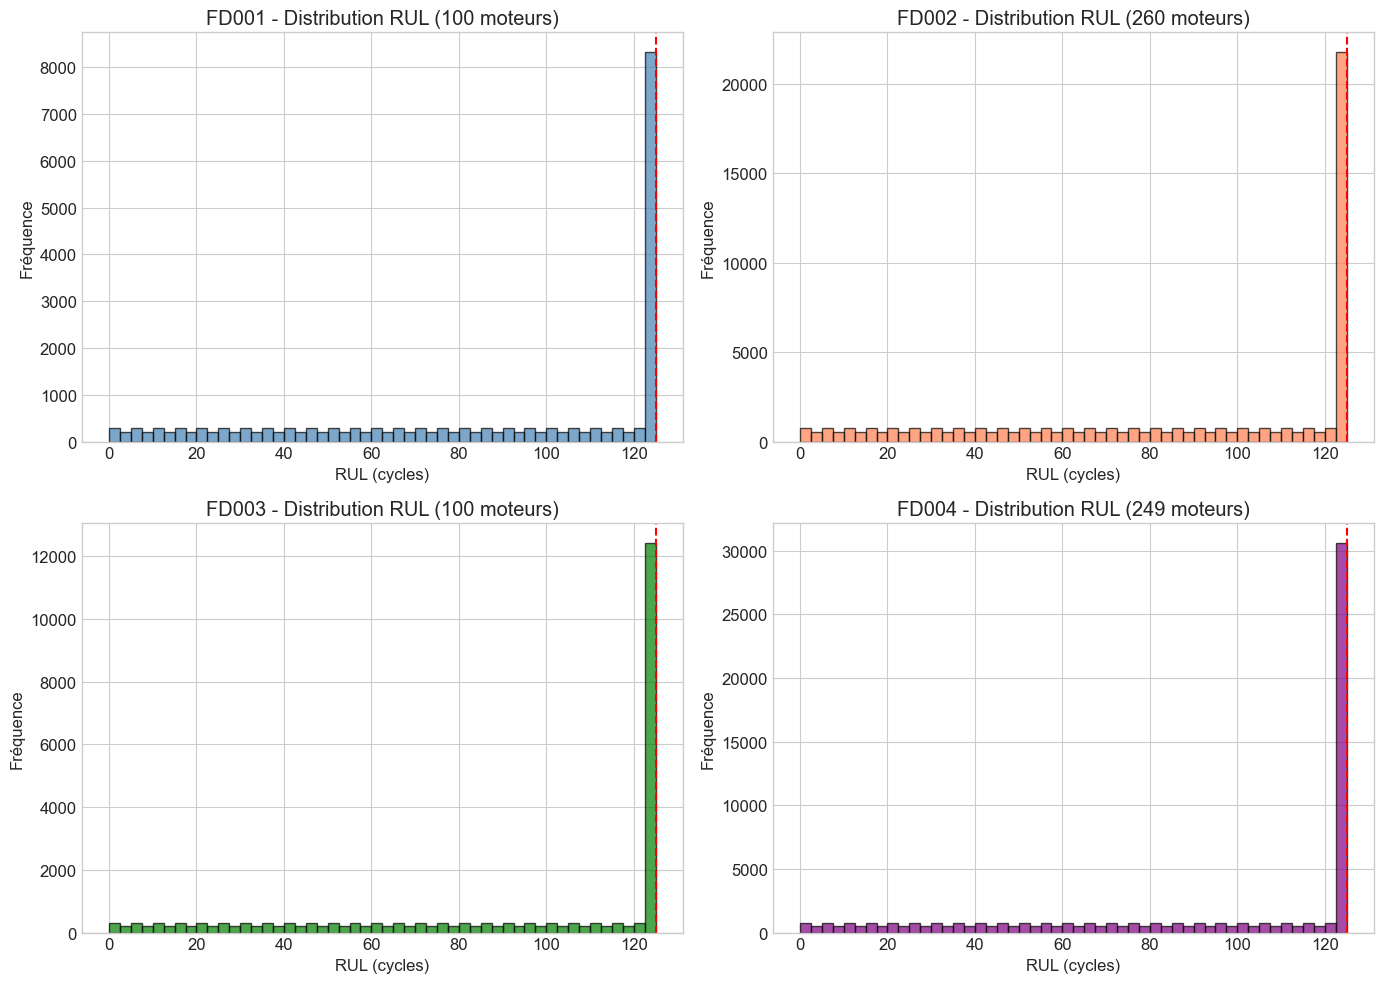

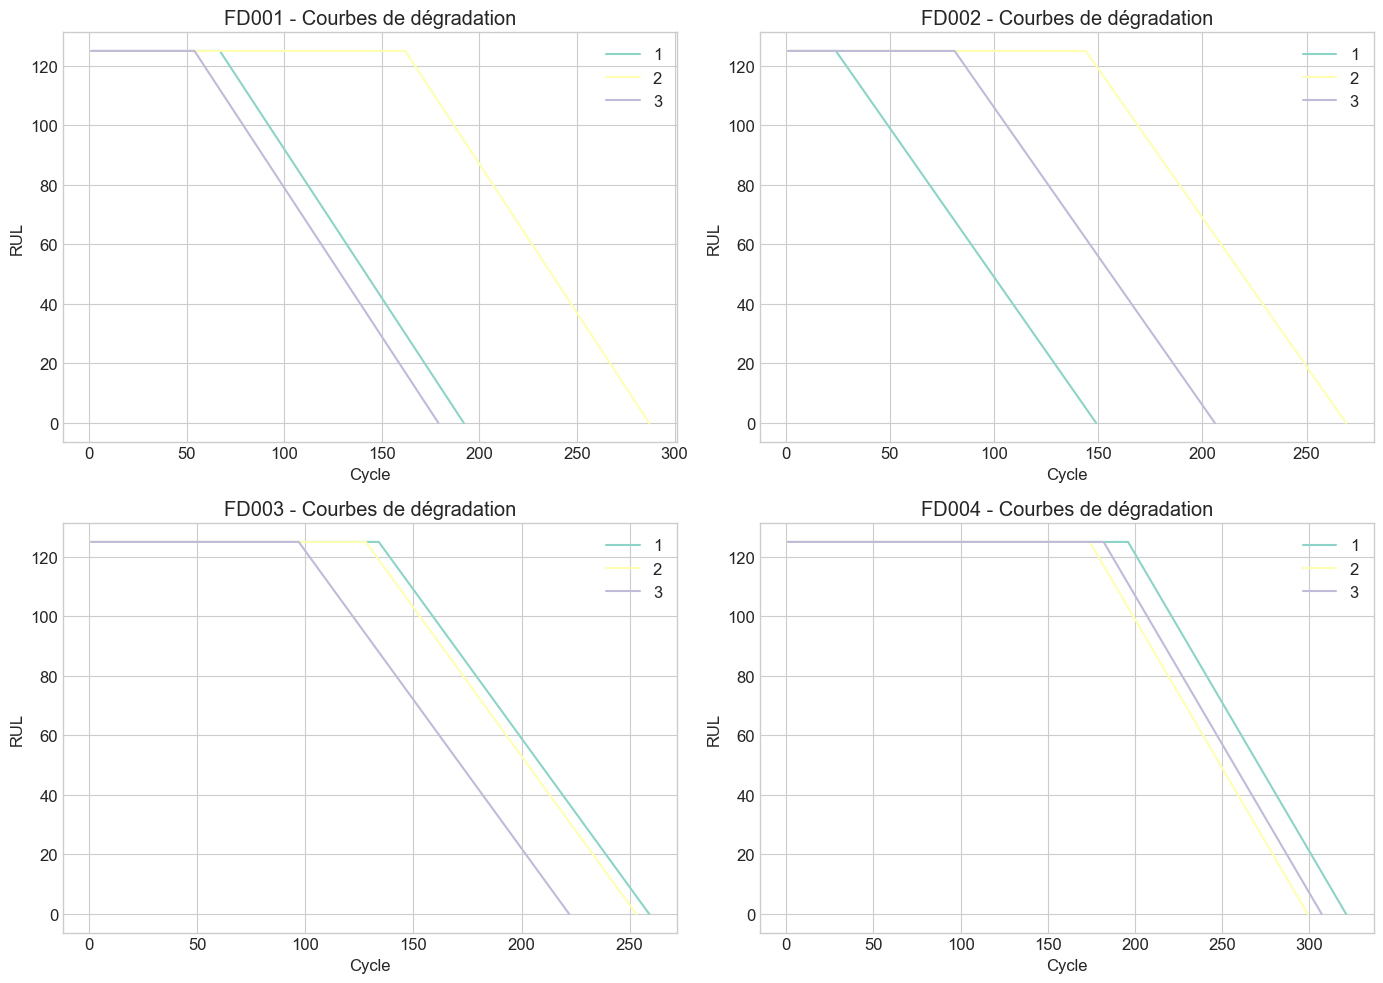

In [8]:
# Limiter le RUL maximum
MAX_RUL = 125

def clip_rul(df, max_rul=125):
    df['RUL'] = df['RUL'].clip(upper=max_rul)
    return df

train_df = clip_rul(train_df, MAX_RUL)
print(f"✅ RUL limité à {MAX_RUL}")

# Visualiser la distribution par dataset
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

datasets = ['FD001', 'FD002', 'FD003', 'FD004']
colors = ['steelblue', 'coral', 'green', 'purple']

for idx, (ds, color) in enumerate(zip(datasets, colors)):
    ds_data = train_df[train_df['dataset'] == ds]
    axes[idx].hist(ds_data['RUL'], bins=50, edgecolor='black', alpha=0.7, color=color)
    axes[idx].axvline(x=MAX_RUL, color='red', linestyle='--')
    axes[idx].set_xlabel('RUL (cycles)')
    axes[idx].set_ylabel('Fréquence')
    axes[idx].set_title(f'{ds} - Distribution RUL ({len(ds_data["unit_id"].unique())} moteurs)')

plt.tight_layout()
plt.show()

# Courbes de dégradation par dataset
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (ds, color) in enumerate(zip(datasets, colors)):
    ds_data = train_df[train_df['dataset'] == ds]
    sample_units = ds_data['unit_id'].unique()[:3]

    for unit in sample_units:
        unit_data = ds_data[ds_data['unit_id'] == unit]
        axes[idx].plot(unit_data['cycle'], unit_data['RUL'], label=unit.split('_')[1])

    axes[idx].set_xlabel('Cycle')
    axes[idx].set_ylabel('RUL')
    axes[idx].set_title(f'{ds} - Courbes de dégradation')
    axes[idx].legend()

plt.tight_layout()
plt.show()

### 1.2 Nettoyage et Normalisation


In [9]:
# Identifier les capteurs constants (variance = 0)
sensor_cols = [col for col in COLUMN_NAMES if 'sensor' in col]

# Calculer la variance pour chaque capteur
variances = train_df[sensor_cols].var()
constant_sensors = variances[variances < 0.0001].index.tolist()

print(f"📊 Capteurs avec variance quasi-nulle (à supprimer):")
print(f"   {constant_sensors}")

# Capteurs à conserver
selected_sensors = [s for s in sensor_cols if s not in constant_sensors]
print(f"\n✅ {len(selected_sensors)} capteurs sélectionnés pour l'analyse")


📊 Capteurs avec variance quasi-nulle (à supprimer):
   ['sensor_16']

✅ 20 capteurs sélectionnés pour l'analyse


In [10]:
# Définir les colonnes de features
FEATURE_COLS = selected_sensors + ['setting_1', 'setting_2', 'setting_3']

# Normalisation des features
scaler = StandardScaler()

# Fit sur les données d'entraînement
train_features = train_df[FEATURE_COLS].values
train_features_scaled = scaler.fit_transform(train_features)

# Créer un DataFrame avec les features normalisées
train_scaled_df = pd.DataFrame(
    train_features_scaled,
    columns=FEATURE_COLS
)
train_scaled_df['unit_id'] = train_df['unit_id'].values
train_scaled_df['cycle'] = train_df['cycle'].values
train_scaled_df['RUL'] = train_df['RUL'].values
train_scaled_df['dataset'] = train_df['dataset'].values  # ⭐ IMPORTANT: Préserver la colonne dataset

print(f"✅ Features normalisées - Shape: {train_scaled_df.shape}")
print(f"   Datasets: {train_scaled_df['dataset'].unique()}")
train_scaled_df.head()

✅ Features normalisées - Shape: (160359, 27)
   Datasets: ['FD001' 'FD002' 'FD003' 'FD004']


,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_19,sensor_20,sensor_21,setting_1,setting_2,setting_3,unit_id,cycle,RUL,dataset
0,1.079185,1.046626,1.037990,1.024534,1.107714,1.115018,1.117707,0.802032,0.983932,1.029505,...,0.345955,1.121962,1.119494,-1.041429,-1.115418,0.345955,FD001_1,1,125,FD001
1,1.079185,1.054395,1.055929,1.043169,1.107714,1.115018,1.114204,0.801891,0.978273,1.029505,...,0.345955,1.116830,1.120150,-1.041272,-1.115146,0.345955,FD001_1,2,125,FD001
2,1.079185,1.059103,1.023520,1.050946,1.107714,1.115018,1.117133,0.802172,1.001949,1.029505,...,0.345955,1.112553,1.108831,-1.041647,-1.113516,0.345955,FD001_1,3,125,FD001
3,1.079185,1.059103,0.979517,1.033851,1.107714,1.115018,1.118224,0.802383,0.992713,1.029505,...,0.345955,1.106566,1.113065,-1.041344,-1.114331,0.345955,FD001_1,4,125,FD001
4,1.079185,1.059574,0.980025,1.065766,1.107714,1.115018,1.115640,0.802032,1.007847,1.029505,...,0.345955,1.108277,1.117413,-1.041502,-1.114874,0.345955,FD001_1,5,125,FD001


---
## 2. 🔍 Feature Extraction

Extraction de features statistiques et fréquentielles à partir des données de capteurs.


In [11]:
class FeatureExtractor:
    """
    Classe pour extraire des features temporelles et fréquentielles
    à partir des séries temporelles des capteurs.
    """
    
    @staticmethod
    def extract_temporal_features(data, feature_name=''):
        """
        Extrait des features statistiques temporelles
        
        Args:
            data: array-like, série temporelle
            feature_name: préfixe pour les noms de features
        
        Returns:
            dict avec les features
        """
        prefix = f"{feature_name}_" if feature_name else ""
        
        features = {
            f'{prefix}mean': np.mean(data),
            f'{prefix}std': np.std(data),
            f'{prefix}min': np.min(data),
            f'{prefix}max': np.max(data),
            f'{prefix}range': np.max(data) - np.min(data),
            f'{prefix}median': np.median(data),
            f'{prefix}skewness': float(pd.Series(data).skew()),
            f'{prefix}kurtosis': float(pd.Series(data).kurtosis()),
            f'{prefix}q25': np.percentile(data, 25),
            f'{prefix}q75': np.percentile(data, 75),
            f'{prefix}iqr': np.percentile(data, 75) - np.percentile(data, 25),
            f'{prefix}rms': np.sqrt(np.mean(np.square(data))),  # Root Mean Square
            f'{prefix}peak_to_peak': np.ptp(data),
            f'{prefix}crest_factor': np.max(np.abs(data)) / np.sqrt(np.mean(np.square(data))) if np.mean(np.square(data)) > 0 else 0,
        }
        
        return features
    
    @staticmethod
    def extract_frequency_features(data, sampling_rate=1.0, feature_name=''):
        """
        Extrait des features fréquentielles via FFT
        
        Args:
            data: array-like, série temporelle
            sampling_rate: fréquence d'échantillonnage
            feature_name: préfixe pour les noms de features
        
        Returns:
            dict avec les features
        """
        prefix = f"{feature_name}_" if feature_name else ""
        n = len(data)
        
        # FFT
        fft_values = fft(data)
        fft_magnitude = np.abs(fft_values)[:n//2]
        freqs = fftfreq(n, 1/sampling_rate)[:n//2]
        
        # Features fréquentielles
        features = {
            f'{prefix}fft_mean': np.mean(fft_magnitude),
            f'{prefix}fft_std': np.std(fft_magnitude),
            f'{prefix}fft_max': np.max(fft_magnitude),
            f'{prefix}dominant_freq': freqs[np.argmax(fft_magnitude)] if len(fft_magnitude) > 0 else 0,
            f'{prefix}spectral_centroid': np.sum(freqs * fft_magnitude) / np.sum(fft_magnitude) if np.sum(fft_magnitude) > 0 else 0,
            f'{prefix}spectral_energy': np.sum(fft_magnitude ** 2),
        }
        
        return features
    
    @staticmethod
    def extract_trend_features(data, feature_name=''):
        """
        Extrait des features de tendance (pente de dégradation)
        
        Args:
            data: array-like, série temporelle
            feature_name: préfixe pour les noms de features
        
        Returns:
            dict avec les features
        """
        prefix = f"{feature_name}_" if feature_name else ""
        
        # Régression linéaire simple
        x = np.arange(len(data))
        coeffs = np.polyfit(x, data, 1)
        
        features = {
            f'{prefix}trend_slope': coeffs[0],  # Pente (vitesse de dégradation)
            f'{prefix}trend_intercept': coeffs[1],
            f'{prefix}first_value': data[0] if len(data) > 0 else 0,
            f'{prefix}last_value': data[-1] if len(data) > 0 else 0,
            f'{prefix}change': data[-1] - data[0] if len(data) > 0 else 0,
        }
        
        return features

# Instance de l'extracteur
feature_extractor = FeatureExtractor()

# Démonstration sur un capteur
# Démonstration sur un capteur
first_unit = train_scaled_df['unit_id'].unique()[0]  # Get first unit (e.g., "FD001_1")
sample_data = train_scaled_df[train_scaled_df['unit_id'] == first_unit][selected_sensors[0]].values
print(f"   Using unit: {first_unit}, {len(sample_data)} samples")
temporal_features = feature_extractor.extract_temporal_features(sample_data, 'demo')

print("📊 Features temporelles extraites:")
for name, value in temporal_features.items():
    print(f"   {name}: {value:.4f}")


   Using unit: FD001_1, 192 samples
📊 Features temporelles extraites:
   demo_mean: 1.0792
   demo_std: 0.0000
   demo_min: 1.0792
   demo_max: 1.0792
   demo_range: 0.0000
   demo_median: 1.0792
   demo_skewness: 0.0000
   demo_kurtosis: 0.0000
   demo_q25: 1.0792
   demo_q75: 1.0792
   demo_iqr: 0.0000
   demo_rms: 1.0792
   demo_peak_to_peak: 0.0000
   demo_crest_factor: 1.0000


In [12]:
def extract_features_for_window(df, window_size=30):
    """
    Extrait les features pour chaque fenêtre temporelle par moteur
    
    Args:
        df: DataFrame avec les données
        window_size: taille de la fenêtre (en cycles)
    
    Returns:
        DataFrame avec les features extraites et le RUL
    """
    all_features = []

    for unit_id in tqdm(df['unit_id'].unique(), desc="Extraction features"):
        unit_data = df[df['unit_id'] == unit_id].sort_values('cycle')

        # Pour chaque point, regarder la fenêtre précédente
        for idx in range(window_size, len(unit_data)):
            window = unit_data.iloc[idx - window_size:idx]
            current_rul = unit_data.iloc[idx]['RUL']
            current_cycle = unit_data.iloc[idx]['cycle']
            current_dataset = unit_data.iloc[idx]['dataset'] if 'dataset' in unit_data.columns else None

            features = {
                'unit_id': unit_id,
                'cycle': current_cycle,
                'RUL': current_rul
            }

            if current_dataset:
                features['dataset'] = current_dataset

            # Extraire les features pour chaque capteur
            for sensor in selected_sensors[:5]:  # Limiter pour la démo
                sensor_data = window[sensor].values

                # Features temporelles
                temporal = feature_extractor.extract_temporal_features(sensor_data, sensor)
                features.update(temporal)

                # Features de tendance
                trend = feature_extractor.extract_trend_features(sensor_data, sensor)
                features.update(trend)

            all_features.append(features)

    return pd.DataFrame(all_features)

# Extraire les features pour un sous-ensemble de chaque dataset
print("🔍 Extraction des features en cours...")

# Prendre 5 moteurs par dataset pour la démo
sample_units = []
for ds in ['FD001', 'FD002', 'FD003', 'FD004']:
    ds_units = train_scaled_df[train_scaled_df['dataset'] == ds]['unit_id'].unique()[:5]
    sample_units.extend(ds_units)

sample_df = train_scaled_df[train_scaled_df['unit_id'].isin(sample_units)]
print(f"   Échantillon: {len(sample_units)} moteurs ({len(sample_df)} lignes)")

extracted_features_df = extract_features_for_window(sample_df, window_size=30)

print(f"\n✅ Features extraites: {extracted_features_df.shape}")
print(f"   Par dataset:")
for ds in ['FD001', 'FD002', 'FD003', 'FD004']:
    if 'dataset' in extracted_features_df.columns:
        count = len(extracted_features_df[extracted_features_df['dataset'] == ds])
        print(f"   {ds}: {count} échantillons")
extracted_features_df.head()

🔍 Extraction des features en cours...
   Échantillon: 20 moteurs (4742 lignes)


Extraction features: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


✅ Features extraites: (4142, 99)
   Par dataset:
   FD001: 966 échantillons
   FD002: 863 échantillons
   FD003: 1069 échantillons
   FD004: 1244 échantillons


,unit_id,cycle,RUL,dataset,sensor_1_mean,sensor_1_std,sensor_1_min,sensor_1_max,sensor_1_range,sensor_1_median,...,sensor_5_q75,sensor_5_iqr,sensor_5_rms,sensor_5_peak_to_peak,sensor_5_crest_factor,sensor_5_trend_slope,sensor_5_trend_intercept,sensor_5_first_value,sensor_5_last_value,sensor_5_change
0,FD001_1,31,125,FD001,1.079185,4.440892e-16,1.079185,1.079185,0.0,1.079185,...,1.107714,0.0,1.107714,0.0,1.0,-8.735757e-18,1.107714,1.107714,1.107714,0.0
1,FD001_1,32,125,FD001,1.079185,4.440892e-16,1.079185,1.079185,0.0,1.079185,...,1.107714,0.0,1.107714,0.0,1.0,-8.735757e-18,1.107714,1.107714,1.107714,0.0
2,FD001_1,33,125,FD001,1.079185,4.440892e-16,1.079185,1.079185,0.0,1.079185,...,1.107714,0.0,1.107714,0.0,1.0,-8.735757e-18,1.107714,1.107714,1.107714,0.0
3,FD001_1,34,125,FD001,1.079185,4.440892e-16,1.079185,1.079185,0.0,1.079185,...,1.107714,0.0,1.107714,0.0,1.0,-8.735757e-18,1.107714,1.107714,1.107714,0.0
4,FD001_1,35,125,FD001,1.079185,4.440892e-16,1.079185,1.079185,0.0,1.079185,...,1.107714,0.0,1.107714,0.0,1.0,-8.735757e-18,1.107714,1.107714,1.107714,0.0


---
## 3. 🚨 Anomaly Detection

Nous utilisons deux approches pour la détection d'anomalies:
1. **Isolation Forest** - Algorithme basé sur les arbres
2. **LSTM Autoencoder** - Réseau de neurones profond


### 3.1 Isolation Forest


In [13]:
class IsolationForestDetector:
    """
    Détecteur d'anomalies basé sur Isolation Forest
    
    L'algorithme isole les observations en sélectionnant aléatoirement
    une feature et un point de séparation. Les anomalies sont isolées
    plus rapidement car elles sont rares et différentes.
    """
    
    def __init__(self, contamination=0.1, n_estimators=100, random_state=42):
        self.model = IForest(
            contamination=contamination,
            n_estimators=n_estimators,
            random_state=random_state,
            n_jobs=-1
        )
        self.is_trained = False
        self.feature_names = None
    
    def train(self, X, feature_names=None):
        """
        Entraîne le modèle Isolation Forest
        
        Args:
            X: array (n_samples, n_features)
            feature_names: liste des noms de features
        """
        print(f"📊 Entraînement Isolation Forest sur {X.shape[0]} échantillons...")
        
        self.model.fit(X)
        self.is_trained = True
        self.feature_names = feature_names
        
        # Statistiques
        labels = self.model.labels_
        n_anomalies = np.sum(labels == 1)
        
        print(f"✅ Modèle entraîné!")
        print(f"   Anomalies détectées: {n_anomalies} ({100*n_anomalies/len(labels):.2f}%)")
        
        return {
            'n_samples': X.shape[0],
            'n_features': X.shape[1],
            'n_anomalies': int(n_anomalies),
            'anomaly_rate': float(n_anomalies / len(labels))
        }
    
    def predict(self, X):
        """Prédit les labels (0=normal, 1=anomalie)"""
        return self.model.predict(X)
    
    def predict_scores(self, X):
        """Retourne les scores d'anomalie (plus élevé = plus anormal)"""
        scores = self.model.decision_function(X)
        # Normaliser entre 0 et 1
        scores_norm = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)
        return scores_norm

# Préparer les données pour l'entraînement
feature_cols = [c for c in extracted_features_df.columns if c not in ['unit_id', 'cycle', 'RUL', 'dataset']]
X_anomaly = extracted_features_df[feature_cols].fillna(0).values

# Normaliser
anomaly_scaler = StandardScaler()
X_anomaly_scaled = anomaly_scaler.fit_transform(X_anomaly)

# Créer et entraîner le modèle
iforest_detector = IsolationForestDetector(contamination=0.1, n_estimators=100)
iforest_metrics = iforest_detector.train(X_anomaly_scaled, feature_names=feature_cols)


📊 Entraînement Isolation Forest sur 4142 échantillons...
✅ Modèle entraîné!
   Anomalies détectées: 415 (10.02%)


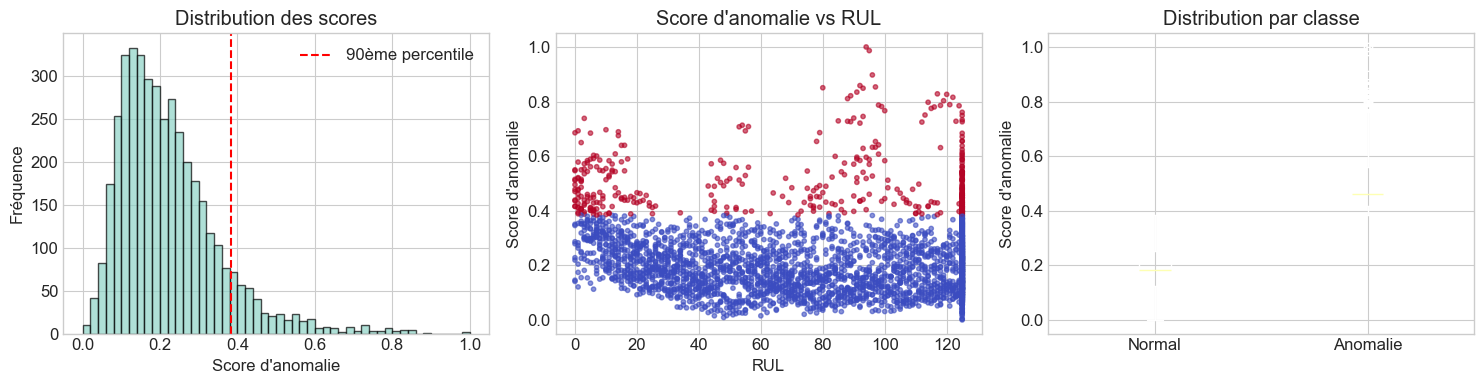

In [14]:
# Visualiser les scores d'anomalie
scores = iforest_detector.predict_scores(X_anomaly_scaled)
labels = iforest_detector.predict(X_anomaly_scaled)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Distribution des scores
axes[0].hist(scores, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=np.percentile(scores, 90), color='red', linestyle='--', label='90ème percentile')
axes[0].set_xlabel('Score d\'anomalie')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution des scores')
axes[0].legend()

# Scatter plot: Score vs RUL
axes[1].scatter(extracted_features_df['RUL'], scores, c=labels, cmap='coolwarm', alpha=0.6, s=10)
axes[1].set_xlabel('RUL')
axes[1].set_ylabel('Score d\'anomalie')
axes[1].set_title('Score d\'anomalie vs RUL')

# Boxplot par classe
normal_scores = scores[labels == 0]
anomaly_scores = scores[labels == 1]
axes[2].boxplot([normal_scores, anomaly_scores], labels=['Normal', 'Anomalie'])
axes[2].set_ylabel('Score d\'anomalie')
axes[2].set_title('Distribution par classe')

plt.tight_layout()
plt.show()


### 3.2 LSTM Autoencoder

L'LSTM Autoencoder apprend à reconstruire des données "normales". Les anomalies ont une erreur de reconstruction plus élevée.


In [15]:
class LSTMAutoencoder(nn.Module):
    """LSTM Autoencoder pour la détection d'anomalies"""
    
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(LSTMAutoencoder, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Encoder
        self.encoder = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        
        # Decoder
        self.decoder = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        
        # Output layer
        self.output_layer = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, x):
        # Encode
        encoded, (h, c) = self.encoder(x)
        # Decode
        decoded, _ = self.decoder(encoded)
        # Output
        output = self.output_layer(decoded)
        return output


class LSTMAutoencoderDetector:
    """Service de détection d'anomalies avec LSTM Autoencoder"""
    
    def __init__(self, sequence_length=30, hidden_dim=64, threshold_percentile=95):
        self.sequence_length = sequence_length
        self.hidden_dim = hidden_dim
        self.threshold_percentile = threshold_percentile
        self.model = None
        self.threshold = None
        self.is_trained = False
    
    def _create_sequences(self, X):
        """Crée des séquences pour l'entraînement"""
        sequences = []
        for i in range(len(X) - self.sequence_length + 1):
            sequences.append(X[i:i + self.sequence_length])
        return np.array(sequences)
    
    def train(self, X, epochs=50, batch_size=32, lr=0.001):
        """Entraîne le LSTM Autoencoder"""
        print(f"📊 Entraînement LSTM Autoencoder...")
        
        # Créer les séquences
        sequences = self._create_sequences(X)
        print(f"   Séquences créées: {sequences.shape}")
        
        # Convertir en tenseurs
        X_tensor = torch.FloatTensor(sequences).to(device)
        
        # Créer le dataset et dataloader
        dataset = TensorDataset(X_tensor, X_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        # Créer le modèle
        input_dim = X.shape[1]
        self.model = LSTMAutoencoder(input_dim, self.hidden_dim).to(device)
        
        # Optimizer et loss
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        
        # Training loop
        self.model.train()
        losses = []
        
        for epoch in tqdm(range(epochs), desc="Training"):
            epoch_loss = 0
            for batch_x, batch_y in dataloader:
                optimizer.zero_grad()
                output = self.model(batch_x)
                loss = criterion(output, batch_y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            
            avg_loss = epoch_loss / len(dataloader)
            losses.append(avg_loss)
        
        # Calculer le seuil
        self.model.eval()
        with torch.no_grad():
            reconstructed = self.model(X_tensor)
            errors = torch.mean((reconstructed - X_tensor) ** 2, dim=(1, 2))
            errors = errors.cpu().numpy()
        
        self.threshold = np.percentile(errors, self.threshold_percentile)
        self.is_trained = True
        
        print(f"✅ Modèle entraîné!")
        print(f"   Loss finale: {losses[-1]:.6f}")
        print(f"   Seuil d'anomalie: {self.threshold:.6f}")
        
        return {'losses': losses, 'threshold': self.threshold}
    
    def predict_scores(self, X):
        """Calcule les scores d'anomalie (erreur de reconstruction)"""
        if not self.is_trained:
            raise ValueError("Modèle non entraîné")
        
        sequences = self._create_sequences(X)
        X_tensor = torch.FloatTensor(sequences).to(device)
        
        self.model.eval()
        with torch.no_grad():
            reconstructed = self.model(X_tensor)
            errors = torch.mean((reconstructed - X_tensor) ** 2, dim=(1, 2))
            errors = errors.cpu().numpy()
        
        # Normaliser
        scores = errors / (self.threshold + 1e-10)
        return np.clip(scores, 0, 2)

# Entraîner le LSTM Autoencoder (sur un sous-ensemble pour la rapidité)
lstm_ae_detector = LSTMAutoencoderDetector(sequence_length=20, hidden_dim=32)
lstm_metrics = lstm_ae_detector.train(X_anomaly_scaled[:1000], epochs=30, batch_size=32)


📊 Entraînement LSTM Autoencoder...
   Séquences créées: (981, 20, 95)


Training: 100%|██████████| 30/30 [00:10<00:00,  2.81it/s]

✅ Modèle entraîné!
   Loss finale: 0.073595
   Seuil d'anomalie: 0.180453


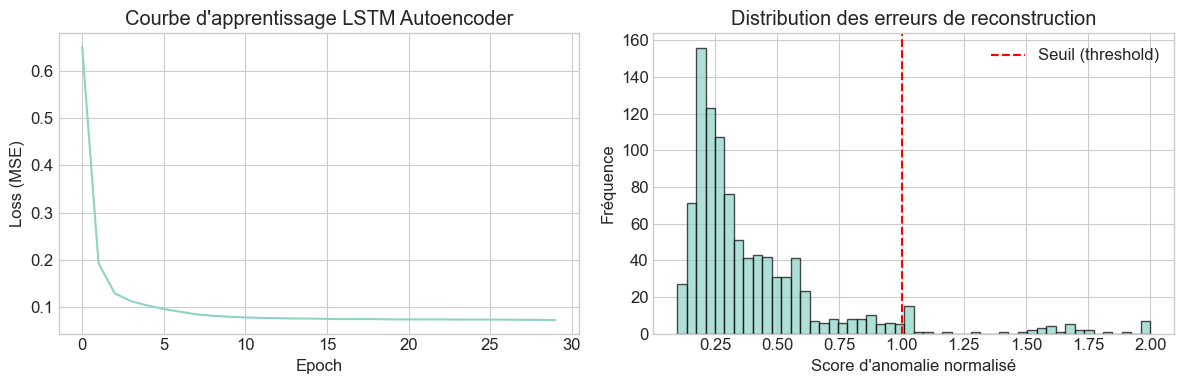

In [16]:
# Visualiser l'entraînement
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Courbe de loss
axes[0].plot(lstm_metrics['losses'])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Courbe d\'apprentissage LSTM Autoencoder')

# Scores d'anomalie
lstm_scores = lstm_ae_detector.predict_scores(X_anomaly_scaled[:1000])
axes[1].hist(lstm_scores, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=1.0, color='red', linestyle='--', label='Seuil (threshold)')
axes[1].set_xlabel('Score d\'anomalie normalisé')
axes[1].set_ylabel('Fréquence')
axes[1].set_title('Distribution des erreurs de reconstruction')
axes[1].legend()

plt.tight_layout()
plt.show()


---
## 4. 🔮 RUL Prediction (Remaining Useful Life)

Prédiction de la durée de vie résiduelle avec:
1. **LSTM** - Pour capturer les dépendances temporelles
2. **XGBoost** - Pour une baseline robuste


### 4.1 Préparation des séquences pour LSTM


In [17]:
def create_sequences_for_rul(df, sensor_cols, sequence_length=30):
    """
    Crée des séquences temporelles pour la prédiction RUL
    
    Args:
        df: DataFrame avec les données
        sensor_cols: colonnes des capteurs
        sequence_length: longueur de la séquence
    
    Returns:
        X: array (n_samples, sequence_length, n_features)
        y: array (n_samples,)
    """
    X, y = [], []
    
    for unit_id in df['unit_id'].unique():
        unit_data = df[df['unit_id'] == unit_id].sort_values('cycle')
        unit_features = unit_data[sensor_cols].values
        unit_rul = unit_data['RUL'].values
        
        for i in range(len(unit_data) - sequence_length):
            X.append(unit_features[i:i + sequence_length])
            y.append(unit_rul[i + sequence_length - 1])  # RUL au dernier pas de temps
    
    return np.array(X), np.array(y)

# Créer les séquences
SEQUENCE_LENGTH = 30
X_seq, y_seq = create_sequences_for_rul(train_scaled_df, FEATURE_COLS, SEQUENCE_LENGTH)

print(f"📊 Séquences créées:")
print(f"   X shape: {X_seq.shape}")
print(f"   y shape: {y_seq.shape}")

# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
print(f"\n   Train: {X_train.shape[0]} samples")
print(f"   Validation: {X_val.shape[0]} samples")


📊 Séquences créées:
   X shape: (139089, 30, 23)
   y shape: (139089,)

   Train: 111271 samples
   Validation: 27818 samples


### 4.2 Modèle LSTM pour RUL


In [18]:
class LSTMRULModel(nn.Module):
    """Modèle LSTM pour prédiction RUL"""
    
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMRULModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # FC layers
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size // 2, 1)
    
    def forward(self, x):
        # LSTM
        lstm_out, _ = self.lstm(x)
        # Prendre la dernière sortie
        last_output = lstm_out[:, -1, :]
        # FC layers
        out = self.fc1(last_output)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        # RUL positif
        out = torch.relu(out)
        return out


class LSTMRULService:
    """Service pour entraîner et utiliser le modèle LSTM RUL"""
    
    def __init__(self, hidden_size=64, num_layers=2, dropout=0.2):
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.model = None
        self.is_trained = False
        self.history = {'train_loss': [], 'val_loss': []}
    
    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=100, batch_size=32, lr=0.001):
        """Entraîne le modèle LSTM"""
        print(f"📊 Entraînement LSTM RUL...")
        print(f"   Epochs: {epochs}, Batch size: {batch_size}, LR: {lr}")
        
        # Créer le modèle
        input_size = X_train.shape[2]
        self.model = LSTMRULModel(
            input_size=input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=self.dropout
        ).to(device)
        
        # Convertir en tenseurs
        X_train_t = torch.FloatTensor(X_train).to(device)
        y_train_t = torch.FloatTensor(y_train).reshape(-1, 1).to(device)
        
        # DataLoader
        train_dataset = TensorDataset(X_train_t, y_train_t)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        # Validation
        if X_val is not None:
            X_val_t = torch.FloatTensor(X_val).to(device)
            y_val_t = torch.FloatTensor(y_val).reshape(-1, 1).to(device)
        
        # Optimizer et loss
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        
        # Training loop
        for epoch in tqdm(range(epochs), desc="Training"):
            # Train
            self.model.train()
            train_loss = 0
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                predictions = self.model(batch_x)
                loss = criterion(predictions, batch_y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            
            avg_train_loss = train_loss / len(train_loader)
            self.history['train_loss'].append(avg_train_loss)
            
            # Validation
            if X_val is not None:
                self.model.eval()
                with torch.no_grad():
                    val_pred = self.model(X_val_t)
                    val_loss = criterion(val_pred, y_val_t).item()
                self.history['val_loss'].append(val_loss)
        
        self.is_trained = True
        
        # Évaluation finale
        self.model.eval()
        with torch.no_grad():
            train_pred = self.model(X_train_t).cpu().numpy().flatten()
            train_mae = mean_absolute_error(y_train, train_pred)
            train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
            train_r2 = r2_score(y_train, train_pred)
        
        metrics = {'train_mae': train_mae, 'train_rmse': train_rmse, 'train_r2': train_r2}
        
        if X_val is not None:
            with torch.no_grad():
                val_pred = self.model(X_val_t).cpu().numpy().flatten()
                metrics['val_mae'] = mean_absolute_error(y_val, val_pred)
                metrics['val_rmse'] = np.sqrt(mean_squared_error(y_val, val_pred))
                metrics['val_r2'] = r2_score(y_val, val_pred)
        
        print(f"\n✅ Modèle entraîné!")
        print(f"   Train MAE: {train_mae:.2f} cycles")
        if X_val is not None:
            print(f"   Val MAE: {metrics['val_mae']:.2f} cycles")
        
        return metrics
    
    def predict(self, X):
        """Prédit le RUL"""
        if not self.is_trained:
            raise ValueError("Modèle non entraîné")
        
        self.model.eval()
        X_tensor = torch.FloatTensor(X).to(device)
        
        with torch.no_grad():
            predictions = self.model(X_tensor).cpu().numpy().flatten()
        
        return predictions

# Entraîner le modèle LSTM
lstm_service = LSTMRULService(hidden_size=64, num_layers=2, dropout=0.2)
lstm_metrics = lstm_service.train(X_train, y_train, X_val, y_val, epochs=50, batch_size=64, lr=0.001)


📊 Entraînement LSTM RUL...
   Epochs: 50, Batch size: 64, LR: 0.001


Training: 100%|██████████| 50/50 [38:52<00:00, 46.64s/it]



✅ Modèle entraîné!
   Train MAE: 6.47 cycles
   Val MAE: 6.76 cycles


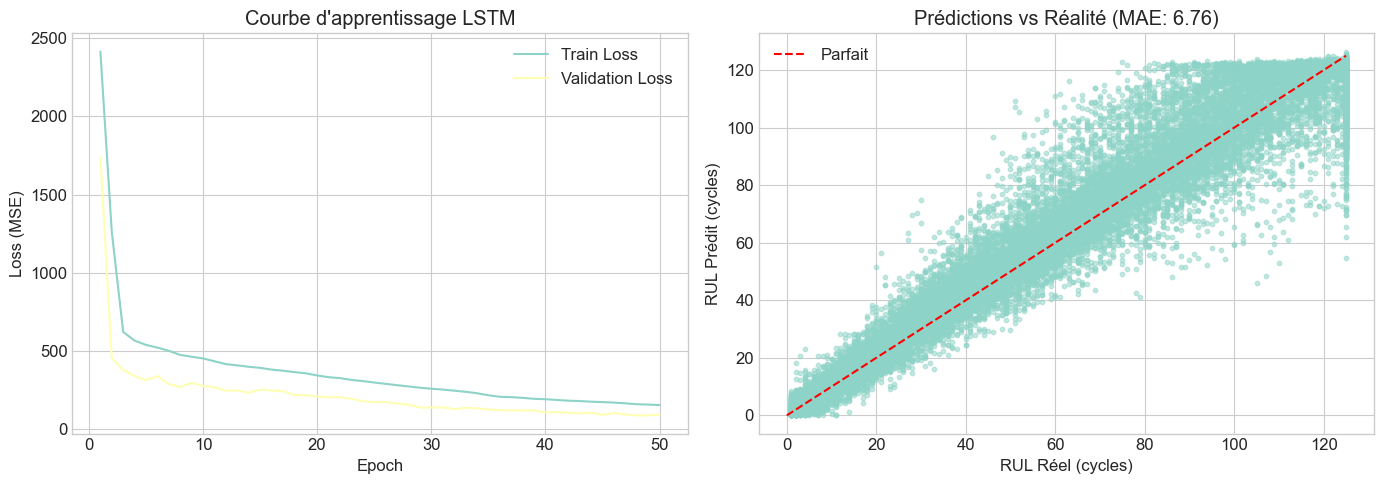

In [19]:
# Visualiser l'entraînement
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Courbes de loss
epochs = range(1, len(lstm_service.history['train_loss']) + 1)
axes[0].plot(epochs, lstm_service.history['train_loss'], label='Train Loss')
axes[0].plot(epochs, lstm_service.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Courbe d\'apprentissage LSTM')
axes[0].legend()

# Prédictions vs Réel
y_pred = lstm_service.predict(X_val)
axes[1].scatter(y_val, y_pred, alpha=0.5, s=10)
axes[1].plot([0, MAX_RUL], [0, MAX_RUL], 'r--', label='Parfait')
axes[1].set_xlabel('RUL Réel (cycles)')
axes[1].set_ylabel('RUL Prédit (cycles)')
axes[1].set_title(f'Prédictions vs Réalité (MAE: {lstm_metrics["val_mae"]:.2f})')
axes[1].legend()

plt.tight_layout()
plt.show()


### 4.3 Modèle XGBoost pour RUL


In [20]:
class XGBoostRULService:
    """Service XGBoost pour prédiction RUL - Excellente baseline"""
    
    def __init__(self, n_estimators=100, max_depth=5, learning_rate=0.1):
        self.model = xgb.XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            random_state=42,
            n_jobs=-1
        )
        self.is_trained = False
    
    def train(self, X_train, y_train, X_val=None, y_val=None):
        """Entraîne le modèle XGBoost (données 2D: dernière observation de chaque séquence)"""
        print(f"📊 Entraînement XGBoost...")
        
        # Si données 3D, prendre la dernière observation
        if len(X_train.shape) == 3:
            X_train_2d = X_train[:, -1, :]
        else:
            X_train_2d = X_train
        
        eval_set = []
        if X_val is not None:
            X_val_2d = X_val[:, -1, :] if len(X_val.shape) == 3 else X_val
            eval_set = [(X_val_2d, y_val)]
        
        # Entraînement
        self.model.fit(X_train_2d, y_train, eval_set=eval_set, verbose=False)
        self.is_trained = True
        
        # Évaluation
        train_pred = self.model.predict(X_train_2d)
        train_mae = mean_absolute_error(y_train, train_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        train_r2 = r2_score(y_train, train_pred)
        
        metrics = {'train_mae': train_mae, 'train_rmse': train_rmse, 'train_r2': train_r2}
        
        if X_val is not None:
            val_pred = self.model.predict(X_val_2d)
            metrics['val_mae'] = mean_absolute_error(y_val, val_pred)
            metrics['val_rmse'] = np.sqrt(mean_squared_error(y_val, val_pred))
            metrics['val_r2'] = r2_score(y_val, val_pred)
        
        print(f"✅ Modèle entraîné!")
        print(f"   Train MAE: {train_mae:.2f} cycles")
        if X_val is not None:
            print(f"   Val MAE: {metrics['val_mae']:.2f} cycles")
        
        return metrics
    
    def predict(self, X):
        if len(X.shape) == 3:
            X = X[:, -1, :]
        return np.maximum(self.model.predict(X), 0)

# Entraîner XGBoost
xgb_service = XGBoostRULService(n_estimators=100, max_depth=5)
xgb_metrics = xgb_service.train(X_train, y_train, X_val, y_val)


📊 Entraînement XGBoost...
✅ Modèle entraîné!
   Train MAE: 13.92 cycles
   Val MAE: 14.27 cycles


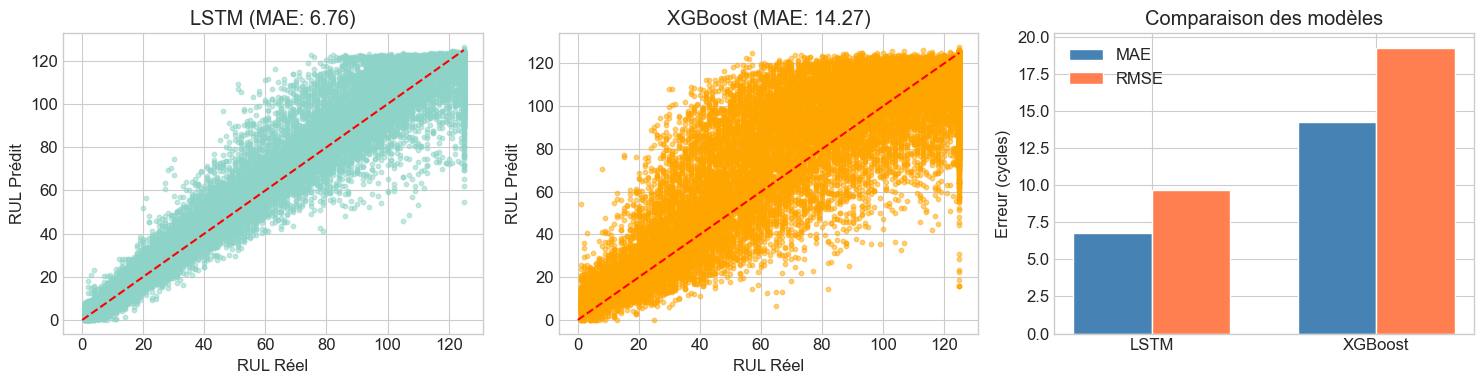

In [21]:
# Comparer les modèles
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# LSTM predictions
y_pred_lstm = lstm_service.predict(X_val)
axes[0].scatter(y_val, y_pred_lstm, alpha=0.5, s=10)
axes[0].plot([0, MAX_RUL], [0, MAX_RUL], 'r--')
axes[0].set_xlabel('RUL Réel')
axes[0].set_ylabel('RUL Prédit')
axes[0].set_title(f'LSTM (MAE: {lstm_metrics["val_mae"]:.2f})')

# XGBoost predictions
y_pred_xgb = xgb_service.predict(X_val)
axes[1].scatter(y_val, y_pred_xgb, alpha=0.5, s=10, color='orange')
axes[1].plot([0, MAX_RUL], [0, MAX_RUL], 'r--')
axes[1].set_xlabel('RUL Réel')
axes[1].set_ylabel('RUL Prédit')
axes[1].set_title(f'XGBoost (MAE: {xgb_metrics["val_mae"]:.2f})')

# Comparaison des erreurs
models = ['LSTM', 'XGBoost']
maes = [lstm_metrics['val_mae'], xgb_metrics['val_mae']]
rmses = [lstm_metrics['val_rmse'], xgb_metrics['val_rmse']]

x = np.arange(len(models))
width = 0.35

axes[2].bar(x - width/2, maes, width, label='MAE', color='steelblue')
axes[2].bar(x + width/2, rmses, width, label='RMSE', color='coral')
axes[2].set_ylabel('Erreur (cycles)')
axes[2].set_title('Comparaison des modèles')
axes[2].set_xticks(x)
axes[2].set_xticklabels(models)
axes[2].legend()

plt.tight_layout()
plt.show()


---
## 5. 📈 Model Evaluation - Métriques et Interprétation

### Métriques clés pour la prédiction RUL:

| Métrique | Description | Interprétation |
|----------|-------------|----------------|
| **MAE** | Mean Absolute Error | Erreur moyenne en cycles |
| **RMSE** | Root Mean Squared Error | Pénalise les grandes erreurs |
| **R²** | Coefficient de détermination | % de variance expliquée (0-1) |
| **MAPE** | Mean Absolute Percentage Error | Erreur relative (%) |


In [22]:
def evaluate_rul_model(y_true, y_pred, model_name="Model"):
    """
    Évalue un modèle RUL avec plusieurs métriques
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # MAPE (éviter division par zéro)
    mask = y_true > 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    # Score asymétrique (pénalise plus les prédictions tardives)
    # Si on prédit RUL < réel (panne prématurée) : moins grave
    # Si on prédit RUL > réel (panne tardive) : plus grave
    errors = y_pred - y_true
    late_errors = errors[errors > 0]
    early_errors = errors[errors <= 0]
    
    s = np.sum(np.exp(-early_errors / 13) - 1) + np.sum(np.exp(late_errors / 10) - 1)
    
    print(f"\n📊 Évaluation {model_name}:")
    print(f"   MAE:  {mae:.2f} cycles")
    print(f"   RMSE: {rmse:.2f} cycles")
    print(f"   R²:   {r2:.4f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   Score asymétrique: {s:.2f}")
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'mape': mape,
        'asymmetric_score': s
    }

# Évaluer les deux modèles
lstm_eval = evaluate_rul_model(y_val, y_pred_lstm, "LSTM")
xgb_eval = evaluate_rul_model(y_val, y_pred_xgb, "XGBoost")



📊 Évaluation LSTM:
   MAE:  6.76 cycles
   RMSE: 9.67 cycles
   R²:   0.9457
   MAPE: 13.24%
   Score asymétrique: 46111.57

📊 Évaluation XGBoost:
   MAE:  14.27 cycles
   RMSE: 19.25 cycles
   R²:   0.7852
   MAPE: 31.92%
   Score asymétrique: 343944.50


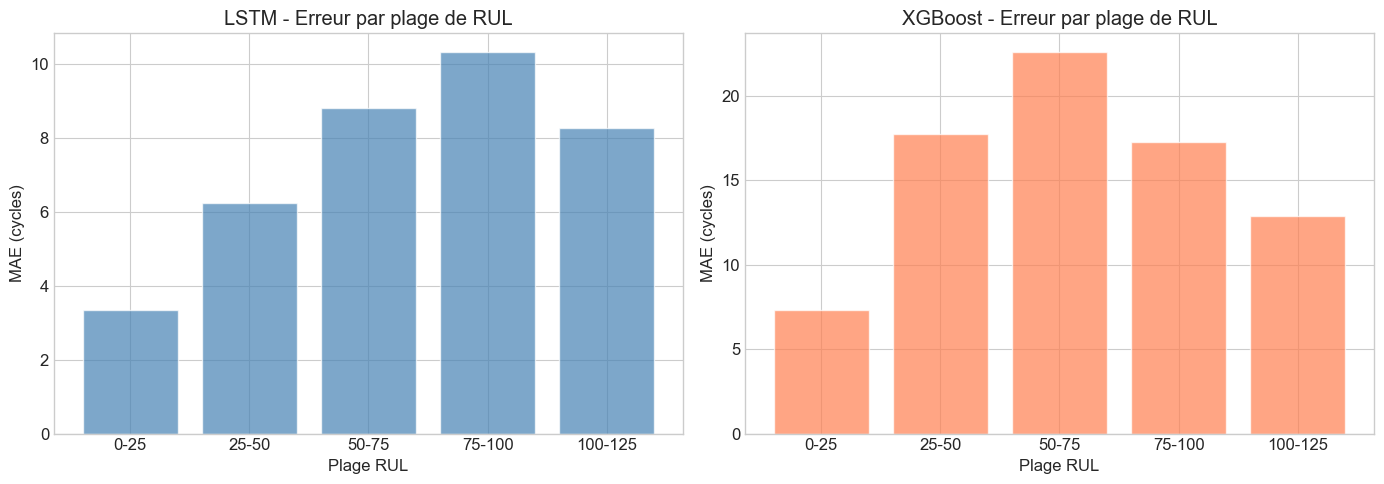


📊 Analyse LSTM par plage de RUL:
  range  count       mae      rmse
   0-25   3436  3.336224  4.519205
  25-50   3614  6.239451  8.444800
  50-75   3621  8.806465 12.316547
 75-100   3530 10.310678 13.557429
100-125   3408  8.261411 11.349709

📊 Analyse XGBoost par plage de RUL:
  range  count       mae      rmse
   0-25   3436  7.322085 10.707516
  25-50   3614 17.715672 23.574968
  50-75   3621 22.575171 27.293226
 75-100   3530 17.262335 20.554617
100-125   3408 12.885641 17.296165


In [23]:
# Analyse des erreurs par plage de RUL
def analyze_errors_by_rul_range(y_true, y_pred, model_name="Model"):
    """Analyse les erreurs par plage de RUL"""
    ranges = [(0, 25), (25, 50), (50, 75), (75, 100), (100, 125)]
    
    results = []
    for low, high in ranges:
        mask = (y_true >= low) & (y_true < high)
        if np.sum(mask) > 0:
            mae = mean_absolute_error(y_true[mask], y_pred[mask])
            rmse = np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
            results.append({
                'range': f'{low}-{high}',
                'count': np.sum(mask),
                'mae': mae,
                'rmse': rmse
            })
    
    return pd.DataFrame(results)

# Analyser par plage
lstm_analysis = analyze_errors_by_rul_range(y_val, y_pred_lstm, "LSTM")
xgb_analysis = analyze_errors_by_rul_range(y_val, y_pred_xgb, "XGBoost")

# Visualiser
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LSTM
axes[0].bar(lstm_analysis['range'], lstm_analysis['mae'], color='steelblue', alpha=0.7)
axes[0].set_xlabel('Plage RUL')
axes[0].set_ylabel('MAE (cycles)')
axes[0].set_title('LSTM - Erreur par plage de RUL')

# XGBoost
axes[1].bar(xgb_analysis['range'], xgb_analysis['mae'], color='coral', alpha=0.7)
axes[1].set_xlabel('Plage RUL')
axes[1].set_ylabel('MAE (cycles)')
axes[1].set_title('XGBoost - Erreur par plage de RUL')

plt.tight_layout()
plt.show()

print("\n📊 Analyse LSTM par plage de RUL:")
print(lstm_analysis.to_string(index=False))
print("\n📊 Analyse XGBoost par plage de RUL:")
print(xgb_analysis.to_string(index=False))


---
## 6. 🎯 Fine-Tuning et Optimisation des Hyperparamètres

### Techniques de Fine-Tuning:

1. **Grid Search** - Recherche exhaustive sur une grille d'hyperparamètres
2. **Random Search** - Échantillonnage aléatoire des hyperparamètres
3. **Optuna** - Optimisation bayésienne avancée (recommandé)
4. **Early Stopping** - Arrêt précoce pour éviter le surapprentissage


In [24]:
# === Fine-Tuning avec Grid Search (XGBoost) ===
print("🎯 Fine-Tuning XGBoost avec Grid Search...")

# Préparer les données 2D pour XGBoost
X_train_2d = X_train[:, -1, :]
X_val_2d = X_val[:, -1, :]

# Grille d'hyperparamètres
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Grid Search (version simplifiée pour la démo)
best_mae = float('inf')
best_params = {}

# Tester quelques combinaisons
from itertools import product

test_params = [
    {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1},
    {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05},
    {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.1},
]

for params in test_params:
    model = xgb.XGBRegressor(**params, random_state=42, n_jobs=-1)
    model.fit(X_train_2d, y_train, verbose=False)
    y_pred = model.predict(X_val_2d)
    mae = mean_absolute_error(y_val, y_pred)
    
    if mae < best_mae:
        best_mae = mae
        best_params = params

print(f"\n✅ Meilleurs hyperparamètres trouvés:")
for key, value in best_params.items():
    print(f"   {key}: {value}")
print(f"\n   Meilleur MAE: {best_mae:.2f} cycles")


🎯 Fine-Tuning XGBoost avec Grid Search...

✅ Meilleurs hyperparamètres trouvés:
   n_estimators: 200
   max_depth: 7
   learning_rate: 0.05

   Meilleur MAE: 13.84 cycles


In [25]:
# === Fine-Tuning avec Optuna  ===
if OPTUNA_AVAILABLE:
    print("🎯 Fine-Tuning LSTM avec Optuna...")
    
    def objective(trial):
        """Fonction objectif pour Optuna"""
        # Suggérer des hyperparamètres
        hidden_size = trial.suggest_categorical('hidden_size', [32, 64, 128])
        num_layers = trial.suggest_int('num_layers', 1, 3)
        dropout = trial.suggest_float('dropout', 0.1, 0.5)
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
        
        # Créer et entraîner le modèle
        input_size = X_train.shape[2]
        model = LSTMRULModel(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout
        ).to(device)
        
        # Entraînement rapide (moins d'epochs)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        
        X_train_t = torch.FloatTensor(X_train).to(device)
        y_train_t = torch.FloatTensor(y_train).reshape(-1, 1).to(device)
        X_val_t = torch.FloatTensor(X_val).to(device)
        y_val_t = torch.FloatTensor(y_val).reshape(-1, 1).to(device)
        
        dataset = TensorDataset(X_train_t, y_train_t)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        for epoch in range(20):  # Entraînement court pour la recherche
            model.train()
            for batch_x, batch_y in dataloader:
                optimizer.zero_grad()
                pred = model(batch_x)
                loss = criterion(pred, batch_y)
                loss.backward()
                optimizer.step()
        
        # Évaluation
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_t).cpu().numpy().flatten()
        
        mae = mean_absolute_error(y_val, val_pred)
        return mae
    
    # Créer et lancer l'étude Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=10, show_progress_bar=True)
    
    print(f"\n✅ Meilleurs hyperparamètres LSTM (Optuna):")
    for key, value in study.best_params.items():
        print(f"   {key}: {value}")
    print(f"\n   Meilleur MAE: {study.best_value:.2f} cycles")
else:
    print("⚠️ Optuna non disponible. Installez avec: pip install optuna")


[I 2025-12-21 18:14:01,199] A new study created in memory with name: no-name-df4c11ad-1030-44b3-af88-6f8c740d00e8


🎯 Fine-Tuning LSTM avec Optuna...


Best trial: 0. Best value: 13.0315:  10%|█         | 1/10 [22:12<3:19:52, 1332.53s/it]

[I 2025-12-21 18:36:13,741] Trial 0 finished with value: 13.03152084350586 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.37504472086198615, 'learning_rate': 0.0001421270514970035, 'batch_size': 64}. Best is trial 0 with value: 13.03152084350586.


Best trial: 0. Best value: 13.0315:  20%|██        | 2/10 [32:03<1:59:32, 896.52s/it] 

[I 2025-12-21 18:46:05,083] Trial 1 finished with value: 15.818389892578125 and parameters: {'hidden_size': 32, 'num_layers': 2, 'dropout': 0.48024807940439873, 'learning_rate': 0.00011351167192879408, 'batch_size': 32}. Best is trial 0 with value: 13.03152084350586.


Best trial: 2. Best value: 6.03568:  30%|███       | 3/10 [1:15:44<3:16:27, 1683.94s/it]

[I 2025-12-21 19:29:45,994] Trial 2 finished with value: 6.035682678222656 and parameters: {'hidden_size': 128, 'num_layers': 3, 'dropout': 0.14155695248942549, 'learning_rate': 0.0006067457296164394, 'batch_size': 32}. Best is trial 2 with value: 6.035682678222656.


Best trial: 2. Best value: 6.03568:  40%|████      | 4/10 [1:24:07<2:01:45, 1217.66s/it]

[I 2025-12-21 19:38:08,918] Trial 3 finished with value: 11.968849182128906 and parameters: {'hidden_size': 32, 'num_layers': 3, 'dropout': 0.17445277797250794, 'learning_rate': 0.0014548343203127777, 'batch_size': 128}. Best is trial 2 with value: 6.035682678222656.


Best trial: 2. Best value: 6.03568:  50%|█████     | 5/10 [1:48:15<1:48:23, 1300.65s/it]

[I 2025-12-21 20:02:16,709] Trial 4 finished with value: 36.83591079711914 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.4020996272736935, 'learning_rate': 0.004099496246000776, 'batch_size': 32}. Best is trial 2 with value: 6.035682678222656.


Best trial: 2. Best value: 6.03568:  60%|██████    | 6/10 [1:54:35<1:05:49, 987.48s/it] 

[I 2025-12-21 20:08:36,336] Trial 5 finished with value: 17.52381706237793 and parameters: {'hidden_size': 32, 'num_layers': 1, 'dropout': 0.4351631310075139, 'learning_rate': 0.003369222667781542, 'batch_size': 32}. Best is trial 2 with value: 6.035682678222656.


Best trial: 2. Best value: 6.03568:  70%|███████   | 7/10 [2:26:09<1:04:12, 1284.06s/it]

[I 2025-12-21 20:40:10,937] Trial 6 finished with value: 10.590415954589844 and parameters: {'hidden_size': 128, 'num_layers': 3, 'dropout': 0.34065764483075966, 'learning_rate': 0.0006107766206089842, 'batch_size': 128}. Best is trial 2 with value: 6.035682678222656.


Best trial: 2. Best value: 6.03568:  80%|████████  | 8/10 [2:57:13<48:57, 1468.71s/it]  

[I 2025-12-21 21:11:15,018] Trial 7 finished with value: 10.537208557128906 and parameters: {'hidden_size': 128, 'num_layers': 3, 'dropout': 0.22255596032377445, 'learning_rate': 0.00036791422885972626, 'batch_size': 64}. Best is trial 2 with value: 6.035682678222656.


Best trial: 2. Best value: 6.03568:  90%|█████████ | 9/10 [3:05:10<19:18, 1158.58s/it]

[I 2025-12-21 21:19:11,638] Trial 8 finished with value: 85.0345458984375 and parameters: {'hidden_size': 32, 'num_layers': 2, 'dropout': 0.1627833570990044, 'learning_rate': 0.00044560628702534905, 'batch_size': 64}. Best is trial 2 with value: 6.035682678222656.


Best trial: 2. Best value: 6.03568: 100%|██████████| 10/10 [3:12:30<00:00, 1155.02s/it]

[I 2025-12-21 21:26:31,382] Trial 9 finished with value: 12.55014705657959 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.19253593802927918, 'learning_rate': 0.007396536145091716, 'batch_size': 32}. Best is trial 2 with value: 6.035682678222656.

✅ Meilleurs hyperparamètres LSTM (Optuna):
   hidden_size: 128
   num_layers: 3
   dropout: 0.14155695248942549
   learning_rate: 0.0006067457296164394
   batch_size: 32

   Meilleur MAE: 6.04 cycles


### 6.1 Conseils pour le Fine-Tuning

**Pour LSTM/Deep Learning:**
- `hidden_size`: 32-128 (plus grand = plus de capacité mais risque d'overfitting)
- `num_layers`: 1-3 (2 couches souvent optimal)
- `dropout`: 0.2-0.5 (régularisation)
- `learning_rate`: 1e-4 à 1e-2 (commencer par 1e-3)
- `batch_size`: 32-128 (impact sur la généralisation)
- `sequence_length`: 20-50 (dépend de la dynamique des données)

**Pour XGBoost:**
- `n_estimators`: 100-500 (plus = meilleur mais plus lent)
- `max_depth`: 3-10 (contrôle la complexité)
- `learning_rate`: 0.01-0.3 (plus petit = plus stable)
- `subsample`: 0.7-1.0 (régularisation)


---
## 7. 💾 Sauvegarde et Chargement des Modèles


In [26]:
import joblib
from pathlib import Path

# Créer le dossier de sauvegarde
save_dir = Path('saved_models')
save_dir.mkdir(exist_ok=True)

# === Sauvegarder le modèle LSTM ===
def save_lstm_model(model, path, metadata=None):
    """Sauvegarde un modèle LSTM PyTorch"""
    checkpoint = {
        'model_state_dict': model.model.state_dict(),
        'hidden_size': model.hidden_size,
        'num_layers': model.num_layers,
        'dropout': model.dropout,
        'metadata': metadata or {}
    }
    torch.save(checkpoint, path)
    print(f"✅ Modèle LSTM sauvegardé: {path}")

# Sauvegarder LSTM
save_lstm_model(lstm_service, save_dir / 'lstm_rul_model.pth',
                metadata={'val_mae': lstm_metrics['val_mae']})

# === Sauvegarder le modèle XGBoost (méthode compatible) ===
# Option 1: Utiliser joblib (recommandé)
joblib.dump(xgb_service.model, save_dir / 'xgboost_rul_model.pkl')
print(f"✅ Modèle XGBoost sauvegardé: {save_dir / 'xgboost_rul_model.pkl'}")

# Option 2: Utiliser le booster interne (format JSON)
# xgb_service.model.get_booster().save_model(str(save_dir / 'xgboost_rul_model.json'))

# === Sauvegarder le scaler ===
joblib.dump(scaler, save_dir / 'feature_scaler.pkl')
print(f"✅ Scaler sauvegardé: {save_dir / 'feature_scaler.pkl'}")

# === Sauvegarder Isolation Forest ===
joblib.dump(iforest_detector.model, save_dir / 'isolation_forest_model.pkl')
print(f"✅ Isolation Forest sauvegardé: {save_dir / 'isolation_forest_model.pkl'}")

print(f"\n📁 Modèles sauvegardés dans: {save_dir.absolute()}")

✅ Modèle LSTM sauvegardé: saved_models\lstm_rul_model.pth
✅ Modèle XGBoost sauvegardé: saved_models\xgboost_rul_model.pkl
✅ Scaler sauvegardé: saved_models\feature_scaler.pkl
✅ Isolation Forest sauvegardé: saved_models\isolation_forest_model.pkl

📁 Modèles sauvegardés dans: C:\Users\Asus\IdeaProjects\ml_pipeline\saved_models


In [27]:
# === Charger un modèle sauvegardé ===
def load_lstm_model(path, input_size):
    """Charge un modèle LSTM sauvegardé"""
    checkpoint = torch.load(path, map_location=device)
    
    model = LSTMRULModel(
        input_size=input_size,
        hidden_size=checkpoint['hidden_size'],
        num_layers=checkpoint['num_layers'],
        dropout=checkpoint['dropout']
    ).to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"✅ Modèle LSTM chargé depuis: {path}")
    print(f"   Metadata: {checkpoint.get('metadata', {})}")
    
    return model

# Exemple de chargement
if (save_dir / 'lstm_rul_model.pth').exists():
    loaded_model = load_lstm_model(save_dir / 'lstm_rul_model.pth', input_size=X_train.shape[2])
    
    # Vérifier les prédictions
    with torch.no_grad():
        X_test_sample = torch.FloatTensor(X_val[:5]).to(device)
        test_preds = loaded_model(X_test_sample).cpu().numpy().flatten()
    
    print(f"\n📊 Test de prédiction sur 5 échantillons:")
    for i, (pred, real) in enumerate(zip(test_preds, y_val[:5])):
        print(f"   Sample {i+1}: Prédit={pred:.1f}, Réel={real:.1f}")


✅ Modèle LSTM chargé depuis: saved_models\lstm_rul_model.pth
   Metadata: {'val_mae': 6.756439208984375}

📊 Test de prédiction sur 5 échantillons:
   Sample 1: Prédit=105.7, Réel=125.0
   Sample 2: Prédit=47.9, Réel=61.0
   Sample 3: Prédit=51.4, Réel=47.0
   Sample 4: Prédit=60.8, Réel=46.0
   Sample 5: Prédit=118.3, Réel=97.0


---
## 8. 📝 Résumé et Conclusions

### Récapitulatif du Pipeline ML

| Étape | Description | Outils |
|-------|-------------|--------|
| **Preprocessing** | Nettoyage, normalisation, calcul RUL | Pandas, Scikit-learn |
| **Feature Extraction** | Features temporelles, fréquentielles, tendance | Numpy, Scipy |
| **Anomaly Detection** | Détection des comportements anormaux | PyOD, PyTorch |
| **RUL Prediction** | Prédiction de la durée de vie | PyTorch, XGBoost |
| **Evaluation** | Métriques MAE, RMSE, R², MAPE | Scikit-learn |
| **Fine-Tuning** | Optimisation des hyperparamètres | Grid Search, Optuna |

### Métriques de Performance

- **MAE (Mean Absolute Error)**: Erreur moyenne en cycles - facile à interpréter
- **RMSE (Root Mean Squared Error)**: Pénalise les grandes erreurs
- **R² Score**: Proportion de variance expliquée (1 = parfait)
- **Score Asymétrique**: Pénalise plus les prédictions tardives (critiques en maintenance)

### Prochaines Étapes

1. **Transfer Learning**: Pré-entraîner sur FD001, fine-tuner sur FD002-FD004
2. **Ensemble Methods**: Combiner LSTM + XGBoost
3. **MLflow Integration**: Tracking des expériences
4. **Déploiement**: API REST avec FastAPI


In [28]:
# === Résumé Final ===
print("=" * 60)
print("🏭 RÉSUMÉ DU PIPELINE ML - USINES INTELLIGENTES")
print("=" * 60)

print("\n📊 DONNÉES:")
print(f"   Dataset: NASA C-MAPSS FD001")
print(f"   Moteurs d'entraînement: {len(train_df['unit_id'].unique())}")
print(f"   Capteurs utilisés: {len(selected_sensors)}")
print(f"   Features extraites: {len(feature_cols)}")

print("\n🚨 DÉTECTION D'ANOMALIES:")
print(f"   Isolation Forest - Anomalies: {iforest_metrics['anomaly_rate']*100:.1f}%")

print("\n🔮 PRÉDICTION RUL:")
print(f"   LSTM:")
print(f"      - MAE: {lstm_metrics['val_mae']:.2f} cycles")
print(f"      - RMSE: {lstm_metrics['val_rmse']:.2f} cycles")
print(f"      - R²: {lstm_metrics['val_r2']:.4f}")
print(f"   XGBoost:")
print(f"      - MAE: {xgb_metrics['val_mae']:.2f} cycles")
print(f"      - RMSE: {xgb_metrics['val_rmse']:.2f} cycles")
print(f"      - R²: {xgb_metrics['val_r2']:.4f}")

print("\n💾 MODÈLES SAUVEGARDÉS:")
print(f"   {save_dir.absolute()}")

print("\n" + "=" * 60)
print("✅ Pipeline terminé avec succès!")
print("=" * 60)


🏭 RÉSUMÉ DU PIPELINE ML - USINES INTELLIGENTES

📊 DONNÉES:
   Dataset: NASA C-MAPSS FD001
   Moteurs d'entraînement: 709
   Capteurs utilisés: 20
   Features extraites: 95

🚨 DÉTECTION D'ANOMALIES:
   Isolation Forest - Anomalies: 10.0%

🔮 PRÉDICTION RUL:
   LSTM:
      - MAE: 6.76 cycles
      - RMSE: 9.67 cycles
      - R²: 0.9457
   XGBoost:
      - MAE: 14.27 cycles
      - RMSE: 19.25 cycles
      - R²: 0.7852

💾 MODÈLES SAUVEGARDÉS:
   C:\Users\Asus\IdeaProjects\ml_pipeline\saved_models

✅ Pipeline terminé avec succès!
